In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 1000)
np.set_printoptions(threshold=1000)

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# 原始数据检查

In [3]:
print("train共有{}行,{}列".format(train.shape[0], train.shape[1]))
print("test共有{}行,{}列".format(test.shape[0], test.shape[1]))

train共有7613行,5列
test共有3263行,4列


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
train.info()
print('-----------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


看一下在训练集中的分布

In [6]:
target_cnt = train['target'].value_counts()
target_cnt = pd.DataFrame(target_cnt)
target_cnt.columns = ['count']
target_cnt.index = ['Not Real', 'Real']
target_cnt

,count
Not Real,4342
Real,3271


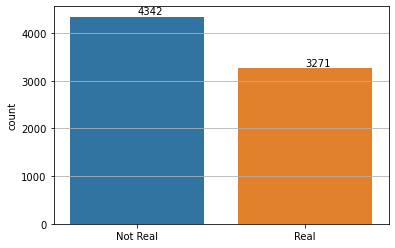

In [7]:
figure, axes = plt.subplots()
sns.barplot(x = target_cnt.index, y = target_cnt['count'], data = target_cnt)
for p in axes.patches:
    axes.annotate(text = int(p.get_height()), xy = (p.get_x() + p.get_width()/2, p.get_height()*1.01))
plt.grid(which = "major", axis = "y")
plt.show()

将每条推特的长度也作为特征值

In [8]:
def length(x):
    return len(x)

train['len'] = train['text'].apply(lambda x: length(x))

查看一下长度的分布情况,注意这是包括空格和字母的字符串长度

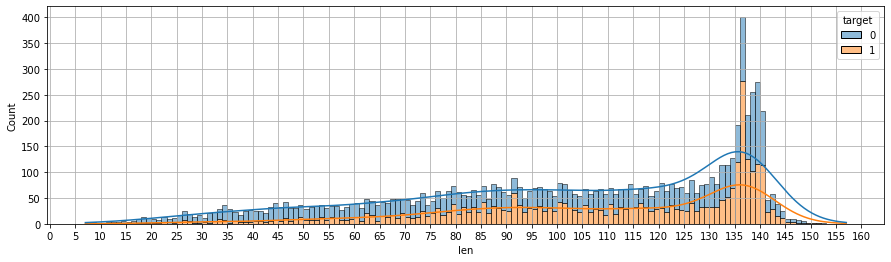

In [9]:
plt.figure(figsize = (15, 4))
sns.histplot(data = train, x = 'len', hue = 'target', kde = True, multiple="stack", bins = 150)
plt.grid(which = "major", axis = "both")
x_major_locator=plt.MultipleLocator(5)
ax=plt.gca()

ax.xaxis.set_major_locator(x_major_locator)

plt.show()

可以看出二者在长度上分布趋势相似,都集中在135-140字符这个区间

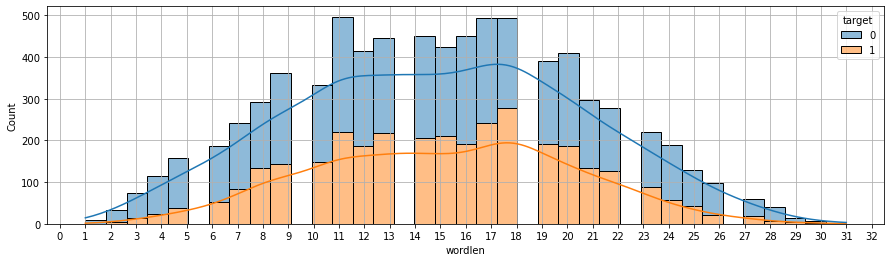

In [10]:
def word_len(x):
    return len(x.split())
train['wordlen'] = train['text'].apply(lambda x: word_len(x))

plt.figure(figsize = (15, 4))
sns.histplot(data = train, x = 'wordlen', hue = 'target', kde = True, multiple="stack")
plt.grid(which = "major", axis = "both")
x_major_locator=plt.MultipleLocator(1)
ax=plt.gca()

ax.xaxis.set_major_locator(x_major_locator)

plt.show()

# 数据清洗与词云制作

需要检查有没有错误的冲突标记,即,两推文内容一致,但一个被标记为1,另一个被标记为0

In [11]:
text = train['text']
# 找出重复的推文
duplicates = train[text.isin(text[text.duplicated()])]
# 如果一个被标记为1,一个被标记为0.那么他们的平均值就不为0或者1
conflicting_check = pd.DataFrame(duplicates.groupby(['text']).target.mean())
# 现在的index其实就是text
conflicting = conflicting_check.loc[(conflicting_check['target'] != 1) & (conflicting_check['target'] != 0)].index
print("冲突个数为" + str(len(conflicting)))
train = train.drop(train[text.isin(conflicting)].index)


冲突个数为18


缩写词转换

需要将url,特殊符号,表情包等奇怪的东西清理掉,并对英文缩写进行转换

In [12]:
import re
import string

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = text.split()
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

def remove_rare(tweet):         
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)

    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    return tweet

In [13]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans(string.punctuation,' ' * len(string.punctuation))
    return text.translate(table)

train['text'] = train['text'].apply(lambda x : remove_rare(x))
train['text']=train['text'].apply(lambda x : remove_url(x))
train['text']=train['text'].apply(lambda x : remove_html(x))
train['text']=train['text'].apply(lambda x : remove_emoji(x))
train['text']=train['text'].apply(lambda x : remove_punct(x))
train['text']=train['text'].apply(lambda x : convert_abbrev_in_text(x))

test['text'] = test['text'].apply(lambda x : remove_rare(x))
test['text']=test['text'].apply(lambda x : remove_url(x))
test['text']=test['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_emoji(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))
test['text']=test['text'].apply(lambda x : convert_abbrev_in_text(x))

下面开始使用词云观察train中灾难推特与非灾难推特中出现得最多的词

In [14]:
disaster_train = train[train['target'] == 1]
not_disaster_train = train[train['target'] == 0]

生成生成高频词列表.为了将部分同时在"灾难"与"非灾难"中的词剔除,这里不能直接调用wordcloud对所有清洗后字符进行处理,而需要:

1. 计数排序高频词汇
2. 去除头部重叠部分
3. 选取去除头部重叠部分后剩余的高频词汇,将其做成一个字符串放入wordcloud中

In [15]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import WordNetLemmatizer   #词形还原库,不做手工标记的前提下效果并不是很好,但是还是可以将复数还原成单数

# 停用词不能作为高频词汇使用
stops = set(stopwords.words('english'))

def word_cnts(dataset, text):
    word_counter = defaultdict(int)
    for token in dataset[text].values:
        token = token.split()
        for word in token:
            word = word.lower()
            # 英文词形还原
            lemmatizer = WordNetLemmatizer()  
            word = lemmatizer.lemmatize(word) 
            if word not in stops:
                word_counter[word] += 1
    return sorted(word_counter, key = word_counter.get, reverse=True)

disaster_sorted = word_cnts(disaster_train, 'text')
not_disaster_sorted = word_cnts(not_disaster_train, 'text')

print("disaster中有{}个正常词汇".format(len(disaster_sorted)))
print("not disaster中有{}个正常词汇".format(len(not_disaster_sorted)))

disaster中有8205个正常词汇
not disaster中有11096个正常词汇


In [16]:
# 如果当前词在对方前300个词中存在,那么视为重叠
disaster_tops_uncleaned = set(disaster_sorted[:300])
not_disaster_tops_uncleaned = set(not_disaster_sorted[:300])

cleaned_disaster = ""
cleaned_not_disaster = ""

# 仅取前50个
entered_cnt = 0
idx = 0
while entered_cnt < 50:
    curword = disaster_sorted[idx]
    if curword not in not_disaster_tops_uncleaned:
        cleaned_disaster += curword + ' '
        entered_cnt += 1
    idx += 1
print("灾难数据在取到第{}位时结束去重".format(idx))

entered_cnt = 0
idx = 0
while entered_cnt < 50:
    curword = not_disaster_sorted[idx]
    if curword not in disaster_tops_uncleaned:
        cleaned_not_disaster += curword + ' '
        entered_cnt += 1
    idx += 1

print("非灾难数据在取到第{}位时结束去重".format(idx))

灾难数据在取到第109位时结束去重
非灾难数据在取到第118位时结束去重


在灾难词条中常出现的词

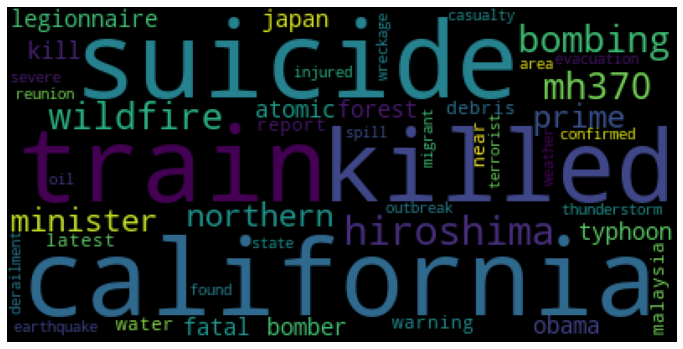

In [17]:
disaster_wordcloud = WordCloud(stopwords = stops).generate(cleaned_disaster)
plt.figure(figsize = (12, 8))
plt.imshow(disaster_wordcloud)
plt.axis('off')
plt.show()

在非灾难词条中经常出现的词

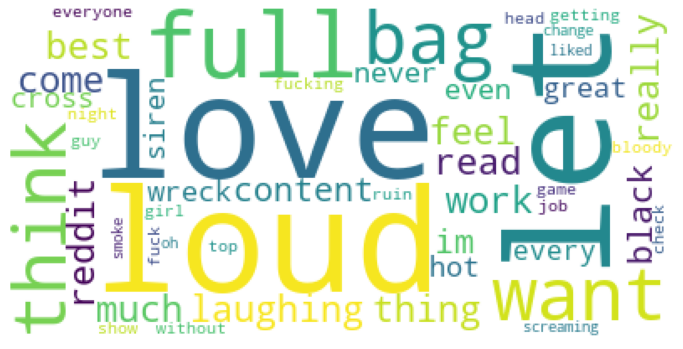

In [18]:
disaster_wordcloud = WordCloud(background_color='white').generate(cleaned_not_disaster)
plt.figure(figsize = (12, 8))
plt.imshow(disaster_wordcloud)
plt.axis('off')
plt.show()

上述词云其实是文本表示方式TF-IDF的简化版

TF-IDF的核心思想是,某个词在某个文档中出现的"几率"越大,这个词对该文档的重要性越大;而包含这个词的文档数越多,这个词对文档的重要性越小.

在上述词云中去重的作用也与其类似,去除同时存在二者中重合高频词,保留他们各自的高频词作为特征

完整TF-IDF的优点:

- 在保留文章的重要词的同时可以过滤掉一些常见的、无关紧要的词(在使用TF-IDF值做词云时,甚至可以不预先对停用词进行处理)

缺点:

- 不能反映词的位置信息，在对关键词进行提取时，词的位置信息（如：标题、句首、句尾的词应该赋予更高的权重）；

- IDF 是一种试图抑制噪声的加权，本身倾向于文本中频率比较小的词，这使得IDF 的精度不高；

- TF-IDF 严重依赖于语料库（尤其在训练同类语料库时，往往会掩盖一些同类型的关键词；如：在进行TF-IDF 训练时，语料库中的 娱乐 新闻较多，则与 娱乐 相关的关键词的权重就会偏低 ），因此需要选取质量高的语料库进行训练；

# TF-IDF

我们现在用TF-IDF尝试一下分类

直接使用scikit-learn中内置的tf-idf向量转换库

In [19]:
y_train = train['target']

In [20]:
def lemmat_words(x):
    regulized_words = ''
    lemmatizer = WordNetLemmatizer()
    x = x.split()
    for word in x:
        word = word.lower()
        if word not in stops:
            word = lemmatizer.lemmatize(word) 
            regulized_words += word + ' '
    return regulized_words

train['text_cleaned'] = train['text'].apply(lambda x: lemmat_words(x))
test['text_cleaned'] = test['text'].apply(lambda x: lemmat_words(x))

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(token_pattern=r'\w{1,}', lowercase=False) #前面已经转小写了,节省时间
train_tfidf = tfidf.fit_transform(train['text_cleaned'])
test_tfidf = tfidf.transform(test["text_cleaned"])

现在看看train_tfidf长啥样

In [22]:
print(train_tfidf.shape)

(7558, 15563)


其中共有7558个句子(推文),15563个单词

train_dfidf中的东西长这样:

In [23]:
train_tfidf.toarray()[:5]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.44672176, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_tfidf, y_train, cv=5, scoring="f1")
scores

array([0.58713693, 0.51668255, 0.57699443, 0.48025614, 0.70504872])

In [25]:
clf.fit(train_tfidf, train["target"])
test_predict = clf.predict(test_tfidf)

In [26]:
submission=pd.DataFrame()
submission['id'] = test['id']
submission['target'] = test_predict
submission.to_csv("submission_tfidf.csv", index=False, header=True)